In [1]:
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
colors = sns.color_palette()

In [2]:
from halotools.empirical_models import HodModelFactory
from halotools.empirical_models import TrivialPhaseSpace, Zheng07Cens
from halotools.empirical_models import NFWPhaseSpace, Zheng07Sats
from halotools.sim_manager import CachedHaloCatalog
from src.redMagicHOD import RedMagicCens, RedMagicSats, StepFuncCens, StepFuncSats

In [3]:
rz = 0.0
cens_prof_model = TrivialPhaseSpace(redshift = rz)
sats_prof_model = NFWPhaseSpace(redshift = rz)
model_instance = HodModelFactory(
        centrals_occupation = StepFuncCens(redshift = rz),
        #centrals_occupation = Zheng07Cens(redshift = rz),
        centrals_profile = cens_prof_model,
        satellites_occupation = StepFuncSats(redshift = rz),
        #satellites_occupation = Zheng07Sats(redshift = rz),
        satellites_profile = sats_prof_model)

In [4]:
#model_instance.param_dict['f_c'] = 0.5

In [5]:
simname = 'chinchilla'
rz = 0.0
version_name = 'Lb400-2048'
size = (400.0)**3
halocat= CachedHaloCatalog(simname = simname, halo_finder = 'rockstar',version_name = version_name, redshift = rz)

In [9]:
idx = halocat.halo_table['halo_mvir'] > 1e15/0.7

In [10]:
halocat.halo_table = halocat.halo_table[idx]

AttributeError: can't set attribute

In [8]:
print '%.2e'%(Out[6]*0.7)

2.05e+15


In [20]:
print halocat.halo_table.colnames, len(halocat.halo_table)

['halo_upid', 'halo_y', 'halo_x', 'halo_z', 'halo_rvir', 'halo_id', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rs', 'halo_mvir', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo'] 19637857


In [21]:
print halocat.Lbox

250.0


In [22]:
model_instance.populate_mock(halocat, Num_ptcl_requirement = 0)

In [23]:
print model_instance.mock.halo_table.colnames, len(model_instance.mock.halo_table)

['halo_upid', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_mvir', 'conc_NFWmodel', 'halo_num_satellites', 'halo_num_centrals'] 16689516


In [33]:
from halotools.mock_observables import return_xyz_formatted_array
from halotools.utils import group_member_generator

halos = model_instance.mock.halo_table

#halos = halos[halos['halo_mvir']> 7e12]

halos.sort(['halo_id', 'halo_upid'])
grouping_key = 'halo_id'
requested_columns = ['halo_num_centrals', 'halo_num_satellites', 'halo_mvir']
group_gen = group_member_generator(halos, grouping_key, requested_columns)

ncen = []
nsat = []
mass = []

for first, last, member_props in group_gen:

    ncen.append(member_props[0][0])
    nsat.append(member_props[1][0])
    mass.append(member_props[2][0]) 
    
ncen = np.array(ncen)
nsat = np.array(nsat)
mass = np.array(mass)

In [34]:
from halotools.mock_observables import mean_y_vs_x
xmin, xmax = 1e11, 1e16
ymin, ymax = 0, 70
halo_mass = np.logspace(np.log10(xmin),np.log10(xmax),100) #bad name, actually mass bins. 

binned_logmass, ncen_hat, ncen_err= mean_y_vs_x(mass, ncen, bins = halo_mass, error_estimator = 'variance')
binned_logmass, nsat_hat, nsat_err= mean_y_vs_x(mass, nsat, bins = halo_mass, error_estimator = 'variance')

nhalo_binned, be = np.histogram(mass, halo_mass)

In [35]:
mean_ncen = model_instance.mean_occupation_centrals(prim_haloprop = halo_mass)
mean_nsat = model_instance.mean_occupation_satellites(prim_haloprop = halo_mass)

In [37]:
print sum(ncen/size - np.ones(mass.shape)/size), sum(nsat/size), 

-1.06755283177 0.0


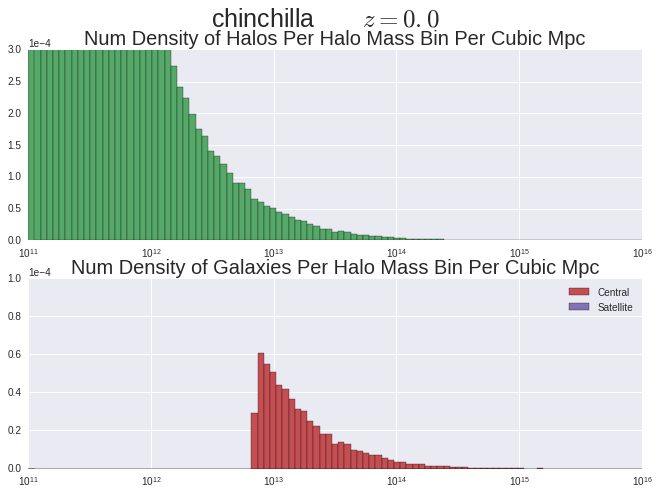

In [41]:
fig = plt.figure(figsize = (11,7.5))

plt.subplot(211)
plt.title("Num Density of Halos Per Halo Mass Bin Per Cubic Mpc",fontsize = 20)

plt.hist(mass, halo_mass, weights = np.ones(mass.shape)/size, color = colors[1])
plt.xscale('log')
plt.ticklabel_format(style='sci', axis='y',scilimits=(0,0))

plt.xlim([xmin,xmax])
plt.ylim([0, 3e-4])

plt.subplot(212)
plt.title("Num Density of Galaxies Per Halo Mass Bin Per Cubic Mpc",fontsize = 20)
plt.hist(mass, halo_mass,weights = ncen/size, color = colors[2], label = 'Central')
plt.hist(mass, halo_mass,weights = nsat/size, color = colors[3], label = 'Satellite')
plt.legend(loc = 'best')

plt.xscale('log')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlim([xmin,xmax])
plt.ylim([0, 1e-4])

plt.suptitle('%s\t $z = %.1f$'%(simname, rz), fontsize = 25)

plt.show()

In [50]:
sample_mask = halocat.halo_table['halo_mvir'] > 7e12
hid, x, y, z = [halocat.halo_table[c] for c in ['halo_id', 'halo_x','halo_y','halo_z'] ]
halo_pos = return_xyz_formatted_array(x,y,z, mask = sample_mask)

In [51]:
x, y, z = [model_instance.mock.galaxy_table[c] for c in ['x','y','z'] ]
gal_pos = return_xyz_formatted_array(x,y,z)

In [52]:
print halo_pos.shape, gal_pos.shape

(9549, 3) (9003, 3)


In [53]:
from itertools import izip

In [69]:
i = 0
for uid, hp, gp in izip(hid[sample_mask], halo_pos, gal_pos):
    print uid, hp, gp
    i+=1
    if i > 100:
        break

2813689433 [ 10.69779968   9.58687019  13.04829025] [ 10.69779968   9.58687019  13.04829025]
2813690469 [ 11.20277023  10.68274021  13.42407036] [ 11.20277023  10.68274021  13.42407036]
2813690957 [ 12.32612991  13.03030968  10.97136974] [ 12.32612991  13.03030968  10.97136974]
2813690958 [ 12.29883003  13.05233002  10.99279022] [ 11.15911007  15.63300991  11.55224991]
2813691844 [ 11.15911007  15.63300991  11.55224991] [ 7.3284502   9.91551018  5.0735302 ]
2813693170 [ 7.3284502   9.91551018  5.0735302 ] [  8.9272604   11.86221027   5.27138996]
2813693645 [  8.9272604   11.86221027   5.27138996] [  8.44285011  10.63560009   4.79407978]
2813693676 [  8.44285011  10.63560009   4.79407978] [ 25.91947937  27.74669075   7.45727015]
2813694467 [ 25.91947937  27.74669075   7.45727015] [ 12.03180027  13.73521996  19.08280945]
2813694864 [ 12.03180027  13.73521996  19.08280945] [ 22.25614929  28.70134926   8.40767956]
2813695331 [ 22.25614929  28.70134926   8.40767956] [  0.50501001   0.638599

In [71]:
h1 = halocat.halo_table['halo_id'] ==2813690957
h2 = halocat.halo_table['halo_id'] ==2813690958

for prop in halocat.halo_table.colnames:
    print prop, '\t',
    print halocat.halo_table[prop][h1][0],'\t',
    print halocat.halo_table[prop][h2][0]

halo_upid 	-1 	2813690957
halo_y 	13.0303 	13.0523
halo_x 	12.3261 	12.2988
halo_z 	10.9714 	10.9928
halo_rvir 	0.883735 	0.460062
halo_id 	2813690957 	2813690958
halo_vx 	-372.06 	-41.96
halo_vy 	184.35 	-52.42
halo_vz 	-13.79 	-265.07
halo_rs 	0.188352 	0.123492
halo_mvir 	7.961e+13 	1.123e+13
halo_nfw_conc 	4.69193 	3.72544
halo_hostid 	2813690957 	2813690957
halo_mvir_host_halo 	7.961e+13 	7.961e+13
